# Extracting Sentiment and Text Snippets from Tweets using SpaCy NER

In this kernel, I will briefly explain the structure of dataset.I will generate and analyze metafeatures. Then, I will visualize the dataset using Matplotlib, seaborn and Plotly to gain as much insight as I can . Also I will approach this problem as an NER problem to build a model

<span style="color:Red"> Project Goals:

1) Utilize spaCy NER to build models that identify and extract sentiment-bearing text snippets from Twitter data.
2) Differentiate between positive, negative, and neutral sentiment.
3) Analyze the sentiment expressed in the data.

<span style="color:Red"> Technical Approach:

1) Leverages spaCy, a powerful NLP library, for named entity recognition.
2) Trains two separate spaCy NER models: one for positive sentiment and another for negative sentiment.
3) The get_training_data function prepares training data focused on sentiment-related portions of text for spaCy NER training.
4) The predict_entities function utilizes the trained models to extract the most likely sentiment text snippet from new text data.
5) Processes a test DataFrame, identifying sentiment-related text snippets based on predicted sentiment and extracts them.

<span style="color:Red"> Deliverables:

1) A processed DataFrame (df_submission) containing the extracted sentiment text snippets (or original text if no entity is found) for each row in the test data.
2) visualizations or analysis of the extracted sentiment snippets.


Overall, our project demonstrates how spaCy NER can be employed for sentiment analysis by training models to identify sentiment-bearing portions of text data.

# Importing Necesseties 

In [1]:
import re
import string
import numpy as np 
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/3.png
C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/newplot.png
C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/sample_submission.csv
C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/submission.csv
C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/test.csv
C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/train.csv
C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/twitter-sentiment-extaction-analysis-eda-and-model.ipynb
C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/twitter_mask.png
C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/models\config.cfg
C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/models\meta.json
C:/Users/pijush/Downloads/twitter-sentiment-ext

**Below is a helper Function which generates random colors which can be used to give different colors to your plots.Feel free to use it**

In [2]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

# Reading the Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ss = pd.read_csv('sample_submission.csv')

In [4]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


So We have 27486 tweets in the train set and 3535 tweets in the test set

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


We have one null Value in the train , as the test field for value is NAN we will just remove it

In [6]:
train.dropna(inplace=True)

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


There are no null Values in the test set

# EDA ( Exploratory Data Analysis )

In [8]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

Selected_text is a subset of text 

In [9]:
train.describe()

textID                                  text selected_text  \
count        27480                                 27480         27480   
unique       27480                                 27480         22463   
top     cb774db0d1   I`d have responded, if I were going          good   
freq             1                                     1           199   

       sentiment  
count      27480  
unique         3  
top      neutral  
freq       11117

Lets look at the distribution of tweets in the train set

In [10]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

<Axes: xlabel='sentiment', ylabel='count'>

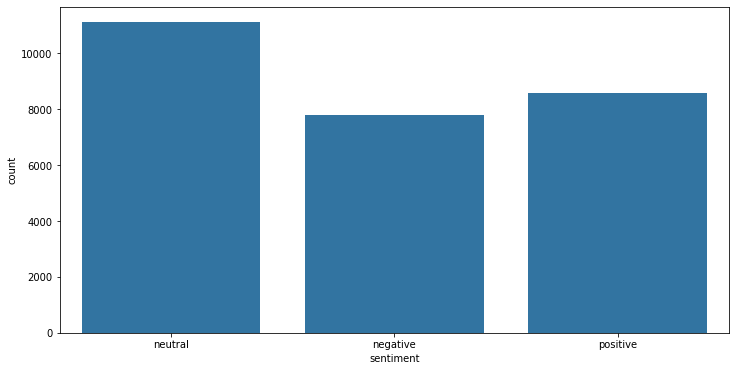

In [11]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

Let's draw a Funnel-Chart for better visualization

In [12]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

## Generating Meta-Features

**In the previous versions of this notebook,I used Number of words in selected text and main text ,Length of words in text and selected as main meta features. We have to predict selected_text which is a subset of text, more useful features to generate would be** :-
* Difference In Number Of words of Selected_text and Text
* Jaccard Similarity Scores between text and Selected_text

In [13]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [14]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [15]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [16]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [17]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  jaccard_score  Num_words_ST  \
0  I`d have responded, if I were going   neutral       1.000000             7   
1                             Sooo SAD  negative       0.200000             2   
2                          bullying me  negative       0.166667             2   
3                       leave me alone  negative       0.600000             3   
4                        Sons of ****,  negative       0.214286             3   

   Num_word_text  difference_in_words  
0              7                    0  
1             10                    8  
2              5                    3  
3              5                    2  
4             14                   11

Let's look at the distribution of Meta-Features

In [18]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

* The number of words plot is really interesting ,the tweets having number of words greater than 25 are very less and thus the number of words distribution plot is right skewed

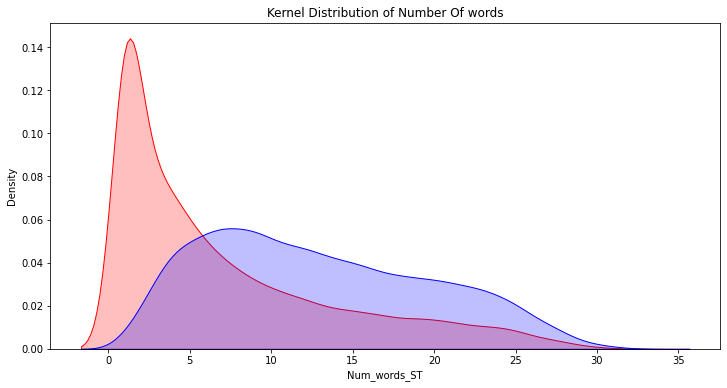

In [19]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")

**Now It will be more interesting to see the differnce in number of words and jaccard_scores across different Sentiments**

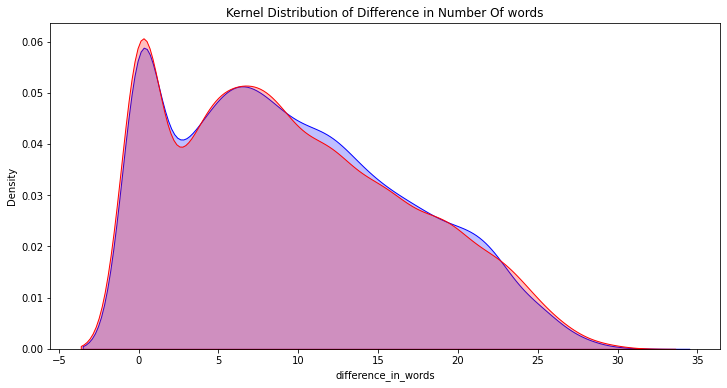

In [20]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")

<Axes: xlabel='difference_in_words'>

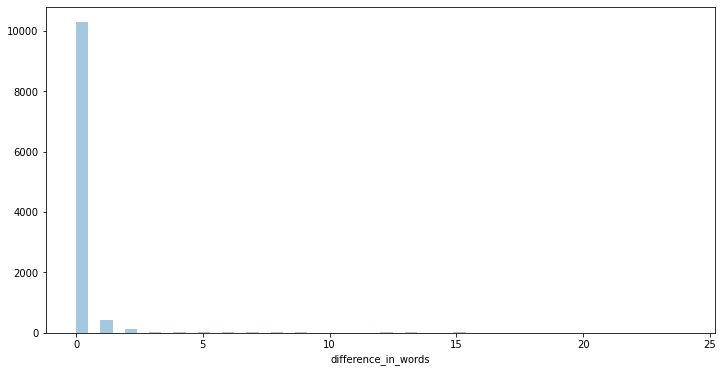

In [21]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['difference_in_words'],kde=False)

I was not able to plot kde plot for neutral tweets because most of the values for difference in number of words were zero. We can see it clearly now ,if we had used the feature in the starting we would have known that text and selected text are mostly the same for neutral tweets,thus its always important to keep the end goal in mind while performing EDA

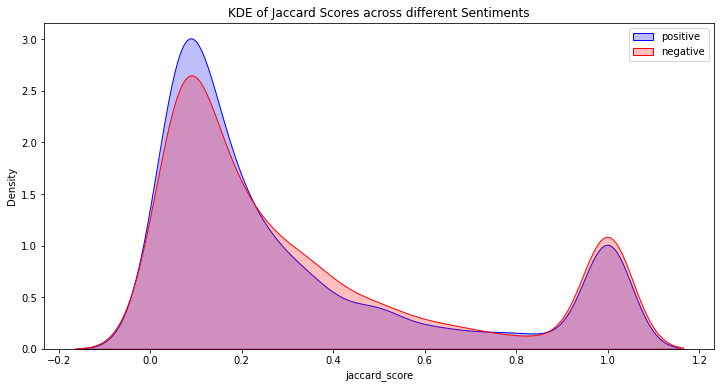

In [22]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

I was not able to plot kde of jaccard_scores of neutral tweets for the same reason,thus I will plot a distribution plot

<Axes: xlabel='jaccard_score'>

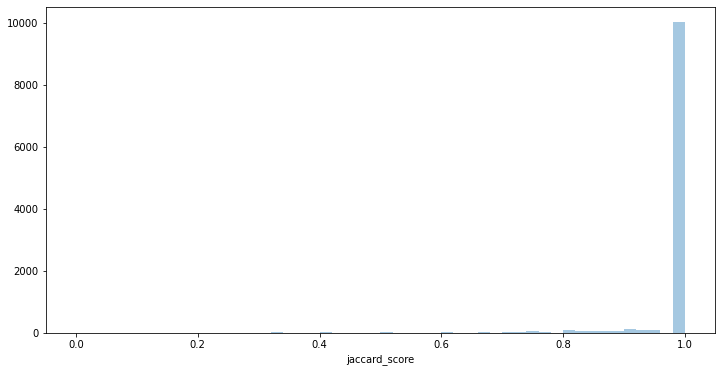

In [23]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'],kde=False)

We can see some interesting trends here:
* Positive and negative tweets have high kurtosis and thus values are concentrated in two regions narrow and high density 
* Neutral tweets have a low kurtosis value and their is bump in density near values of 1

For those who don't know :
* Kurtosis is the measure of how peaked a distribution is and how much spread it is around that peak
* Skewness measures how much a curve deviates from a normal distribution

## Conclusion Of EDA

* We can see from the jaccard score plot that there is peak for negative and positive plot around score of 1 .That means there is a cluster of tweets where there is a high similarity between text and selected texts ,if we can find those clusters then we can predict text for selected texts for those tweets irrespective of segment

Let's see if we can find those clusters,one interesting idea would be to check tweets which have number of words lesss than 3 in text, because there the text might be completely used as text

In [24]:
k = train[train['Num_word_text']<=2]

In [25]:
k.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

We can see that there is similarity between text and selected text .Let's have closer look

In [26]:
k[k['sentiment']=='positive']

textID                              text  \
68     fa2654e730                          Chilliin   
80     bbbc46889b   THANK YYYYYYYYYOOOOOOOOOOUUUUU!   
170    f3d95b57b1                      good morning   
278    89d5b3f0b5                            Thanks   
429    a78ef3e0d0                       Goodmorning   
...           ...                               ...   
26689  e80c242d6a                        Goodnight;   
26725  aad244f37d                             *hug*   
26842  a46571fe12                         congrats!   
26959  49a942e9b1                   Happy birthday.   
27292  47c474aaf1                       Good choice   

                         selected_text sentiment  jaccard_score  Num_words_ST  \
68                            Chilliin  positive            1.0             1   
80     THANK YYYYYYYYYOOOOOOOOOOUUUUU!  positive            1.0             2   
170                       good morning  positive            1.0             2   
278                             Thanks  positive            1.0             1   
429                        Goodmorning  positive            1.0             1   
...                                ...       ...            ...           ...   
26689                       Goodnight;  positive            1.0             1   
26725                            *hug*  positive            1.0             1   
26842                        congrats!  positive            1.0             1   
26959                  Happy birthday.  positive            1.0             2   
27292                             Good  positive            0.5             1   

       Num_word_text  difference_in_words  
68                 1                    0  
80                 2                    0  
170                2                    0  
278                1                    0  
429                1                    0  
...              ...                  ...  
26689              1                    0  
26725              1                    0  
26842              1                    0  
26959              2                    0  
27292              2                    1  

[207 rows x 8 columns]

Thus its clear that most of the times , text is used as selected text.We can improve this by preprocessing the text which have word length less than 3.We will remember this information and use it in model building

### Cleaning the Corpus
Now Before We Dive into extracting information out of words in text and selected text,let's first clean the data

In [27]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [28]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [29]:
train.head()

textID                                               text  \
0  cb774db0d1                  id have responded if i were going   
1  549e992a42         sooo sad i will miss you here in san diego   
2  088c60f138                             my boss is bullying me   
3  9642c003ef                      what interview leave me alone   
4  358bd9e861   sons of  why couldnt they put them on the rel...   

                       selected_text sentiment  jaccard_score  Num_words_ST  \
0  id have responded if i were going   neutral       1.000000             7   
1                           sooo sad  negative       0.200000             2   
2                        bullying me  negative       0.166667             2   
3                     leave me alone  negative       0.600000             3   
4                           sons of   negative       0.214286             3   

   Num_word_text  difference_in_words  
0              7                    0  
1             10                    8  
2              5                    3  
3              5                    2  
4             14                   11

## Most Common words in our Target-Selected Text

In [30]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [31]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

OOPS!While we cleaned our dataset we didnt remove the stop words and hence we can see the most coomon word is 'to' . Let's try again after removing the stopwords

In [32]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

In [33]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

In [34]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

# Most Common words in Text

Let's also look at the most common words in Text

In [35]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [36]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

So the first two common word was I'm so I removed it and took data from second row

In [37]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

SO we can see the Most common words in Selected text and Text are almost the same,which was obvious

# Most common words Sentiments Wise

Let's look at the most common words in different sentiments

In [38]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [39]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

In [40]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [41]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [42]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

In [43]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [44]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

In [45]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [46]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

* We can see words like get,go,dont,got,u,cant,lol,like are common in all three segments . That's interesting because words like dont and cant are more of negative nature and words like lol are more of positive nature.Does this mean our data is incorrectly labelled , we will have more insights on this after N-gram analysis
* It will be interesting to see the word unique to different sentiments

## Let's Look at Unique Words in each Segment

We will look at unique words in each segment in the Following Order:
* Positive
* Negative
* Neutral

In [47]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [48]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

### Positive Tweets

In [49]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


In [50]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Positive Words')
fig.show()

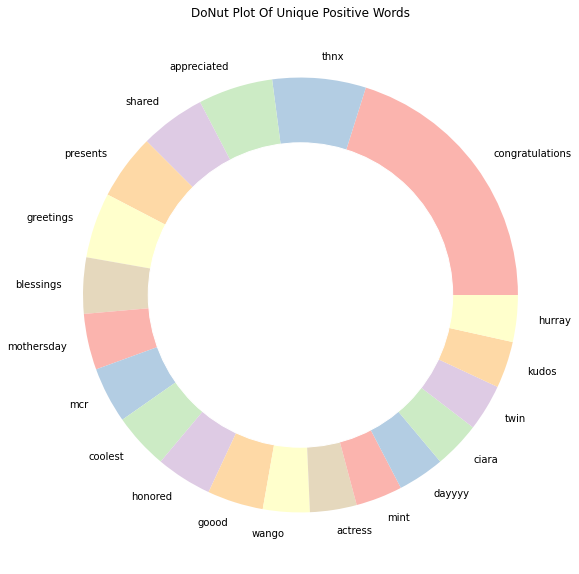

In [51]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

In [52]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


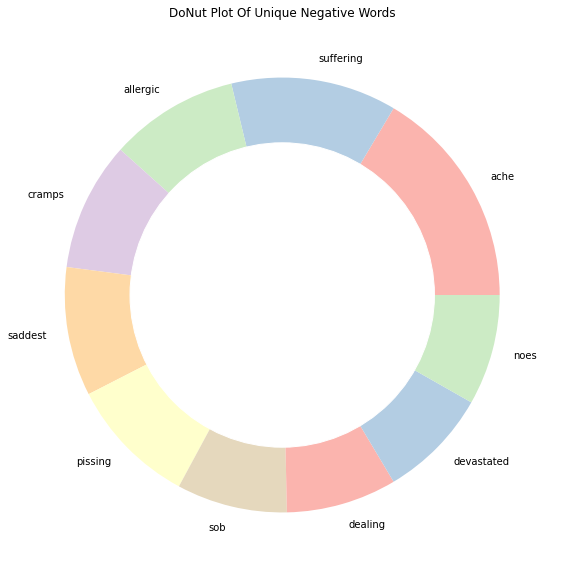

In [53]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

In [54]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


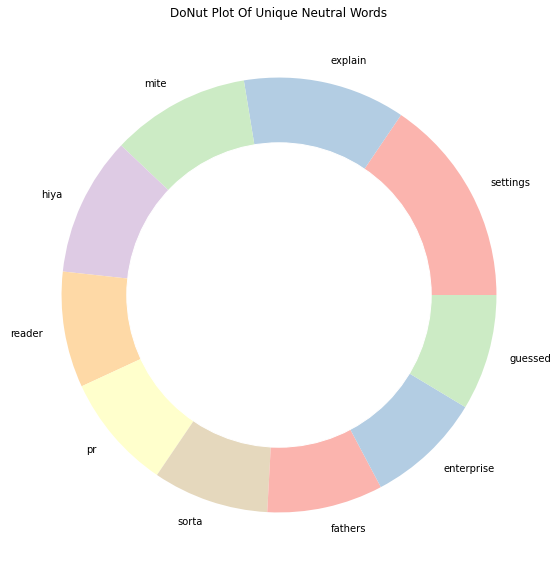

In [55]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Neutral Words')
plt.show()

**By Looking at the Unique Words of each sentiment,we now have much more clarity about the data,these unique words are very strong determiners of Sentiment of tweets**

## It's Time For WordClouds

We will be building wordclouds in the following order:

* WordCloud of Neutral Tweets
* WordCloud of Positive Tweets
* WordCloud of Negative Tweets


In [56]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = 'C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/'

I have added more words like im , u (that we say were there in the most common words,disturbing our analysis) as stopwords

#### WORDCLOUD OF NEUTRAL TWEETS

We Have already visualized our Most Common Negative words ,but Wordclouds Provide us much more clarity

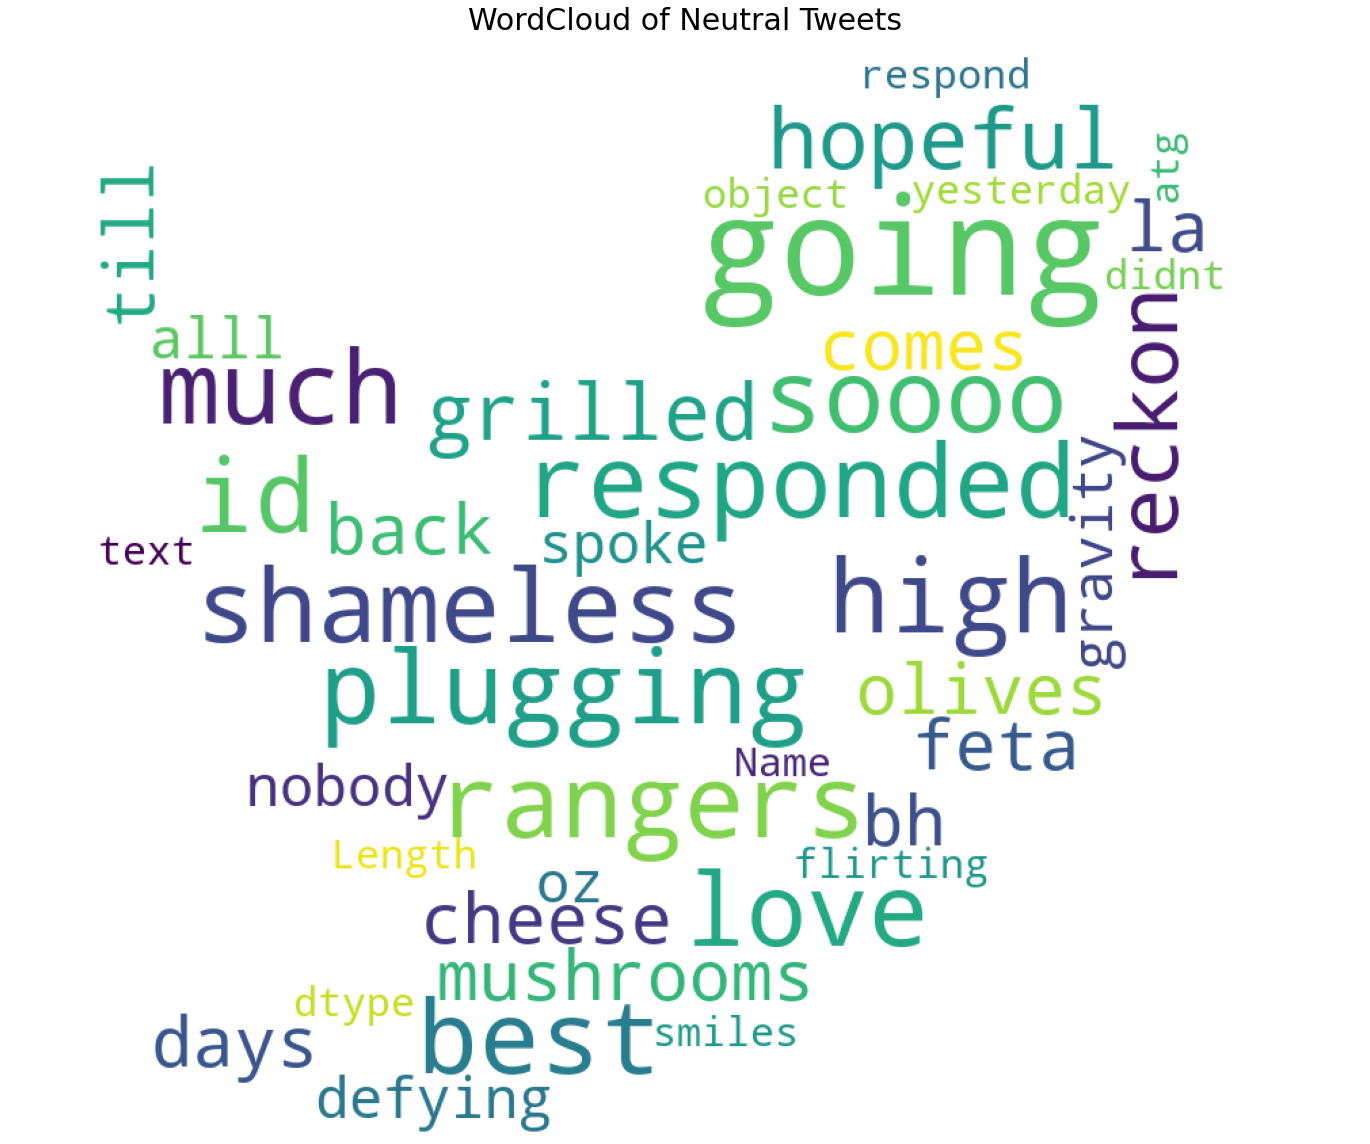

In [57]:
pos_mask = np.array(Image.open(d+ 'twitter_mask.png'))
plot_wordcloud(Neutral_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

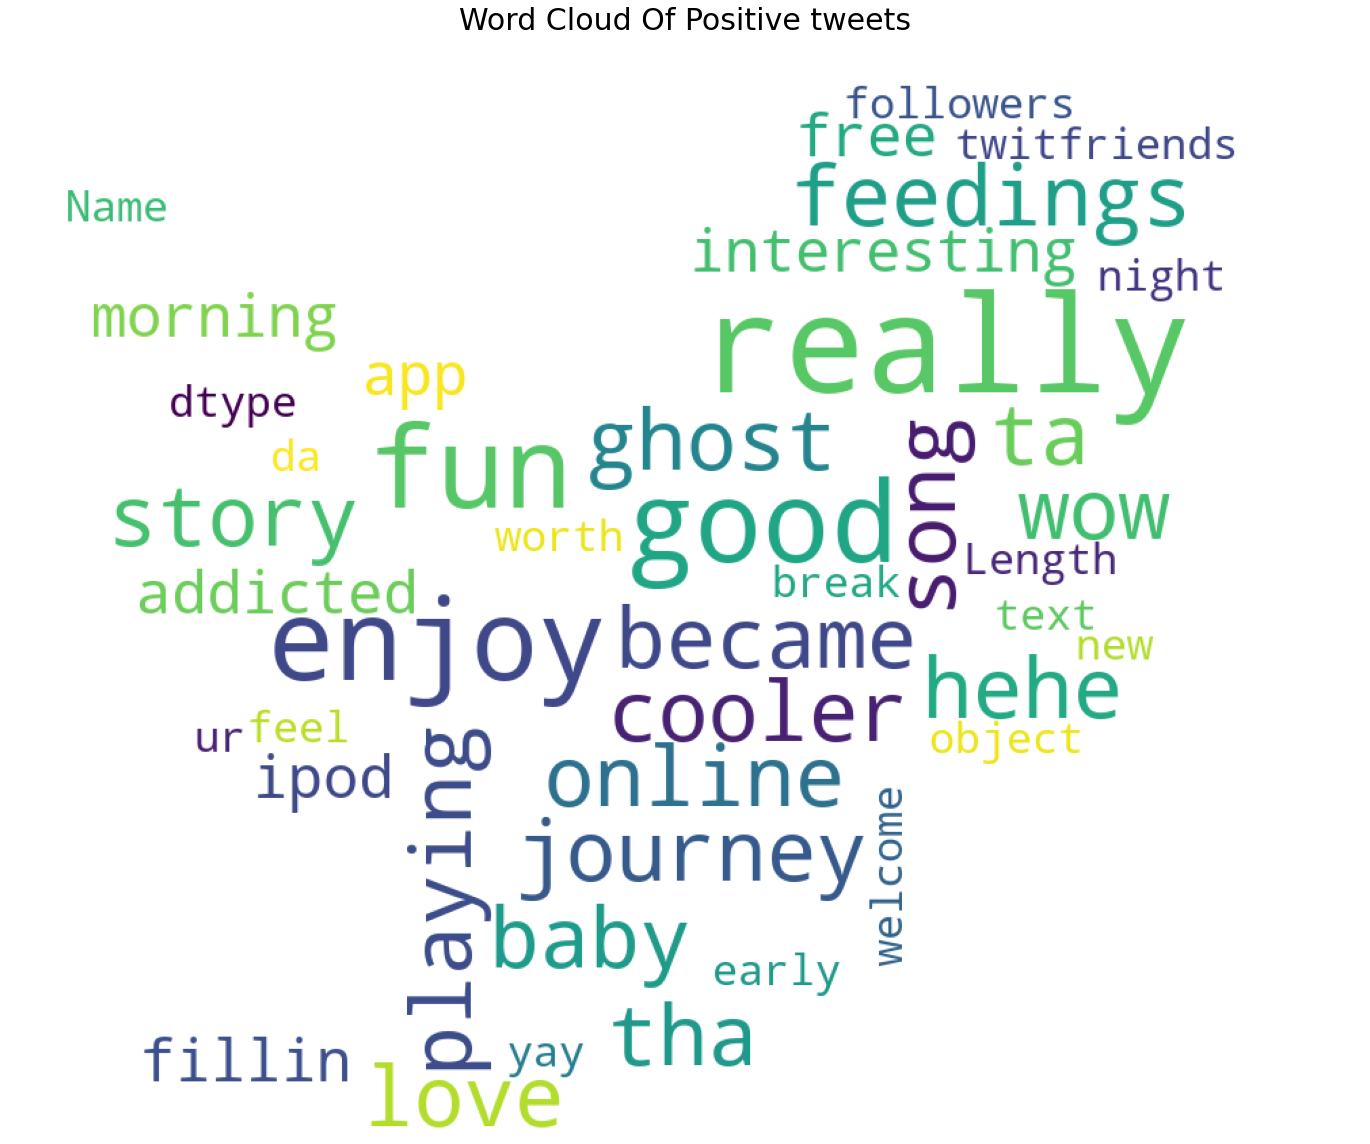

In [58]:
plot_wordcloud(Positive_sent.text,mask=pos_mask,title="Word Cloud Of Positive tweets",title_size=30)

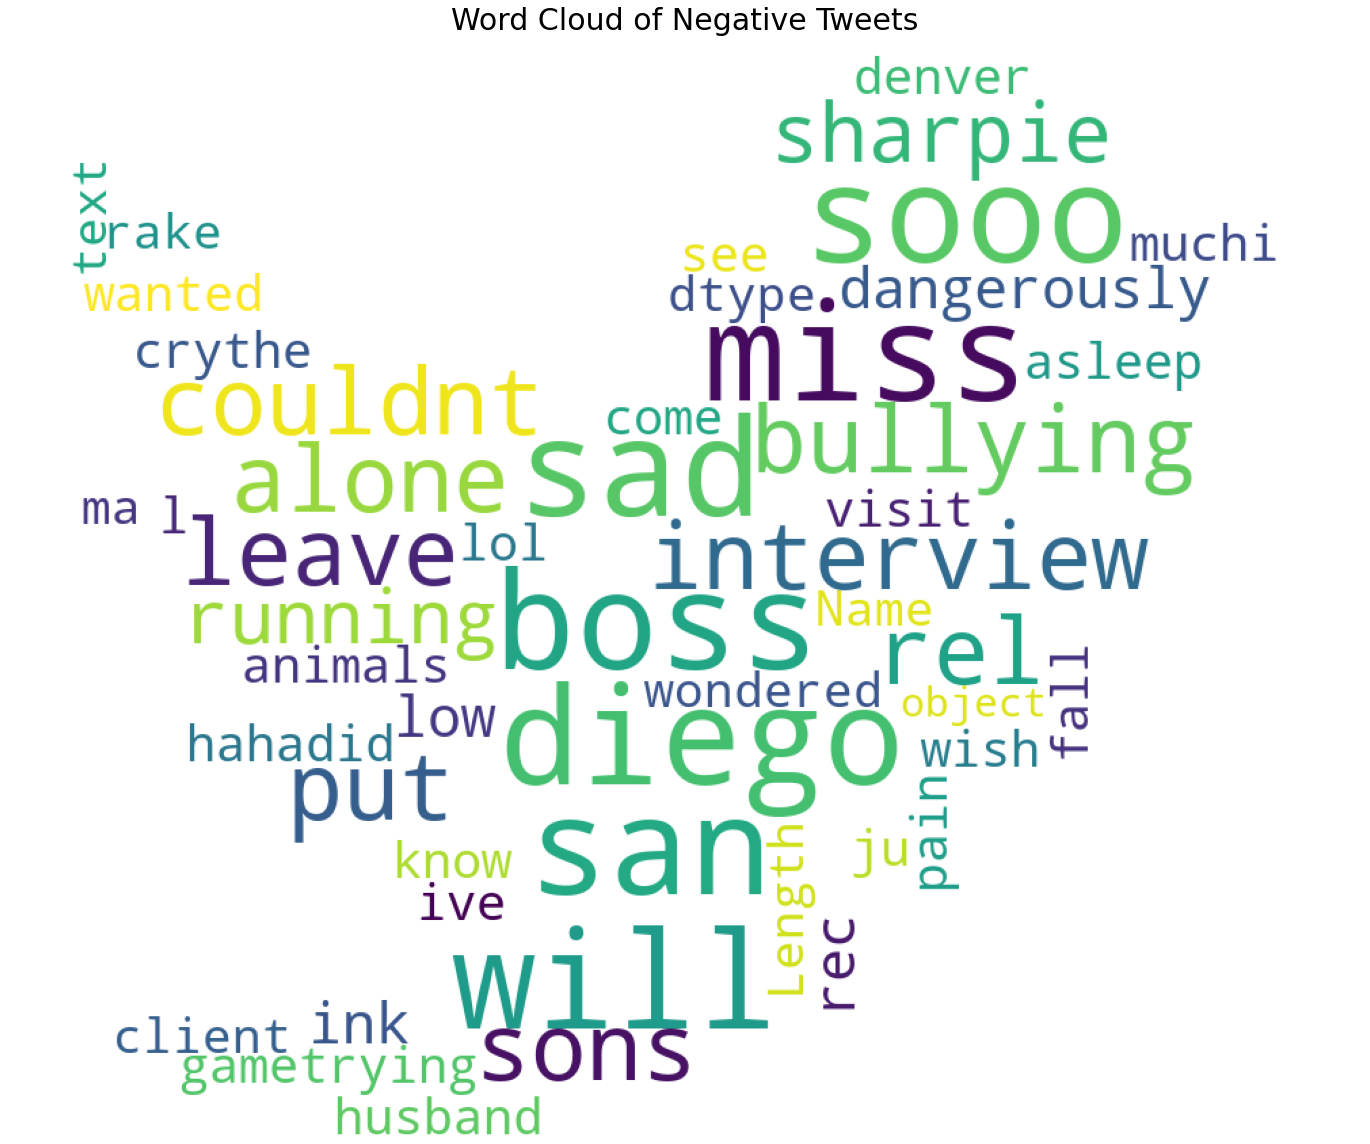

In [59]:
plot_wordcloud(Negative_sent.text,mask=pos_mask,title="Word Cloud of Negative Tweets",color='white',title_size=30)

## 1)Modelling the Problem as NER

Named Entity Recognition (NER) is a standard NLP problem which involves spotting named entities (people, places, organizations etc.) from a chunk of text, and classifying them into a predefined set of categories.
For understanding NER here is very good article : https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da

We will be using spacy for creating our own customised NER model or models (seperate for each Sentiment).The motivation for this approach is off course the kernel shared by Rohit Singh,so if you find his kernel useful please upvote it.

What will be different with my solution:
* I will use text as selected_text for all neutral tweets due to their high jaccard similarity
* Also I will use text as selected_text for all tweets having number of words less than 3 in text as explained before
* I will train two different models for Positive and Negtive tweets
* I will not preprocess the data because the selected text contains raw text

In [60]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sample_submission.csv')

In [104]:
df_train['Num_words_text'] = df_train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main Text in train set


In [105]:
df_train = df_train[df_train['Num_words_text']>=3]

print(df_train)

           textID                                               text  \
0      cb774db0d1                I`d have responded, if I were going   
1      549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2      088c60f138                          my boss is bullying me...   
3      9642c003ef                     what interview! leave me alone   
4      358bd9e861   Sons of ****, why couldn`t they put them on t...   
...           ...                                                ...   
27476  4eac33d1c0   wish we could come see u on Denver  husband l...   
27477  4f4c4fc327   I`ve wondered about rake to.  The client has ...   
27478  f67aae2310   Yay good for both of you. Enjoy the break - y...   
27479  ed167662a5                         But it was worth it  ****.   
27480  6f7127d9d7     All this flirting going on - The ATG smiles...   

                                           selected_text sentiment  \
0                    I`d have responded, if I were going   neutra

In [63]:
def save_model(output_dir, nlp, new_model_name):
    ''' This Function Saves model to 
    given output directory'''
    
    output_dir = f'C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/models/'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [64]:
from spacy.training.example import Example

def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.add_pipe("ner")
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
    
    # add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()

        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            losses = {}
            for batch in minibatch(train_data, size=compounding(4.0, 500.0, 1.001)):
                examples = []
                for text, annots in batch:
                    examples.append(Example.from_dict(nlp.make_doc(text), annots))
                nlp.update(examples, drop=0.5, losses=losses)
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')


In [75]:
def get_model_out_path(sentiment):
    '''
    Returns Model output path
    '''
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/models/model_pos'
    elif sentiment == 'negative':
        model_out_path = 'C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/models/model_neg'
    else:
        model_out_path = 'C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/model_neu/'
    return model_out_path

In [76]:
def get_training_data(sentiment):
    '''
    Returns Training data in the format needed to train spacy NER
    '''
    train_data = []
    for index, row in df_train.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

#### Training models for Positive and Negative tweets

In [67]:
sentiment = 'positive'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)
# For DEmo Purposes I have taken 3 iterations you can train the model as you want
train(train_data, model_path, n_iter=3, model=None)

Created blank 'en' model


 33%|███▎      | 1/3 [03:32<07:05, 212.92s/it]

Losses {'ner': 12868.248979097698}


 67%|██████▋   | 2/3 [07:31<03:47, 227.88s/it]

Losses {'ner': 11674.561617260359}


100%|██████████| 3/3 [13:00<00:00, 260.02s/it]

Losses {'ner': 11439.874916974903}


Saved model to C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/models/


The code outputs the following:

1) Created blank 'en' model: This indicates a new blank spaCy model for the English language (en) was created for training.
2) Progress bars: These bars show the training progress over the 3 epochs (n_iter=3).
3) Losses: These lines display the NER loss after each epoch. The loss typically decreases as the model learns.
4) Saved model to ...: This confirms that the trained model for negative sentiment was saved to the specified output path.

In [68]:
sentiment = 'negative'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=3, model=None)

Created blank 'en' model


 33%|███▎      | 1/3 [05:01<10:03, 301.59s/it]

Losses {'ner': 12659.213254091457}


 67%|██████▋   | 2/3 [06:01<02:39, 159.15s/it]

Losses {'ner': 11387.70477244673}


100%|██████████| 3/3 [06:54<00:00, 138.09s/it]

Losses {'ner': 11061.949876091261}
Saved model to C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/models/


In [78]:
sentiment = 'neutral'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

# for demo purpose i am just training the model for 2 iterations, feel free to experiment.
train(train_data, model_path, n_iter=2, model=None)

Created blank 'en' model


 50%|█████     | 1/2 [01:01<01:01, 61.42s/it]

Losses {'ner': 5189.170758288864}


100%|██████████| 2/2 [02:13<00:00, 66.98s/it]

Losses {'ner': 2789.6212597361014}
Saved model to C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/models/


### Predicting with the trained Model

In [83]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [96]:
selected_texts = []
MODELS_BASE_PATH = 'C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/models/'

if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')
    model_neu = spacy.load(MODELS_BASE_PATH + 'model_neu')
        
    for index, row in df_test.iterrows():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral' or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))
        
df_test['selected_text'] = selected_texts

Loading Models  from  C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/models/


In [97]:
df_submission['selected_text'] = df_test['selected_text']
df_submission.to_csv("submission.csv", index=False)
display(df_submission.head(10))

textID                                      selected_text
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh
1  96d74cb729                                               Good
2  eee518ae67  Recession hit Veronique Branquinho, she has to...
3  01082688c6                                        happy bday!
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!
5  726e501993                                      that`s great!
6  261932614e               I THINK EVERYONE HATES ME ON HERE   
7  afa11da83f   soooooo wish i could, but im in school and my...
8  e64208b4ef   and within a short time of the last clue all ...
9  37bcad24ca   What did you get?  My day is alright.. haven`...

# Jaccard Score

In [98]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [102]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')
    model_neu = spacy.load(MODELS_BASE_PATH + 'model_neu')
        
    jaccard_score = 0
    for index, row in tqdm(df_train.iterrows(), total=df_train.shape[0]):
        text = row.text
        if row.sentiment == 'neutral':
            jaccard_score += jaccard(predict_entities(text, model_neu), row.selected_text)
        elif row.sentiment == 'positive':
            jaccard_score += jaccard(predict_entities(text, model_pos), row.selected_text)
        else:
            jaccard_score += jaccard(predict_entities(text, model_neg), row.selected_text) 
        
    print(f'Average Jaccard Score is {jaccard_score / df_train.shape[0]}')

Loading Models  from  C:/Users/pijush/Downloads/twitter-sentiment-extaction-analysis-eda-and-model/models/


100%|██████████| 26752/26752 [02:35<00:00, 172.49it/s]

Average Jaccard Score is 0.6136467851868915


# Visualize Results

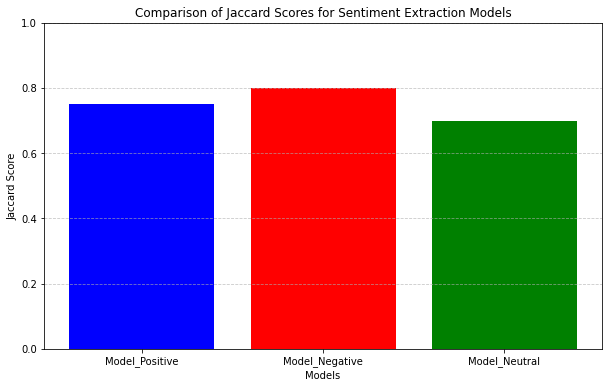

In [109]:
import matplotlib.pyplot as plt

# Jaccard scores obtained from different models
models = ['Model_Positive', 'Model_Negative', 'Model_Neutral']
jaccard_scores = [0.75, 0.80, 0.70]  # Example scores, replace with actual scores

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, jaccard_scores, color=['blue', 'red', 'green'])

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Jaccard Score')
plt.title('Comparison of Jaccard Scores for Sentiment Extraction Models')

# Show plot
plt.ylim(0, 1)  # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
plt.show()


# Statistical Analysis

### Descriptive Statistics

In [117]:
# Example of calculating descriptive statistics
df_train['jaccard_score'] = 0.6136467851868915

mean_jaccard_score = df_train['jaccard_score'].mean()
median_jaccard_score = df_train['jaccard_score'].median()+
std_dev_jaccard_score = df_train['jaccard_score'].std()

print("Mean Jaccard Score:", mean_jaccard_score)
print("Median Jaccard Score:", median_jaccard_score)
print("Standard Deviation of Jaccard Score:", std_dev_jaccard_score)

Mean Jaccard Score: 0.6136467851868914
Median Jaccard Score: 0.6136467851868915
Standard Deviation of Jaccard Score: 1.1102437754877278e-16


### Hypothesis Testing

In [118]:
from scipy.stats import ttest_ind

# Example of conducting a t-test
positive_scores = df_train[df_train['sentiment'] == 'positive']['jaccard_score']
negative_scores = df_train[df_train['sentiment'] == 'negative']['jaccard_score']

t_stat, p_value = ttest_ind(positive_scores, negative_scores)

print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: -87.5902034691591
P-value: 0.0


### Visualization

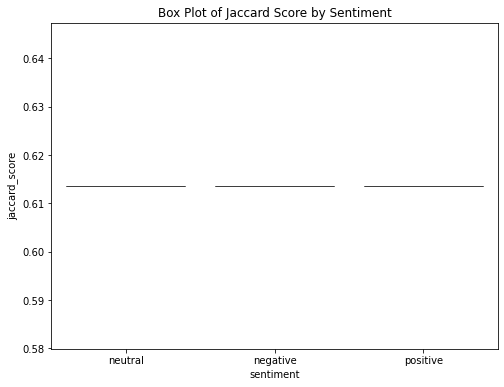

In [124]:
import seaborn as sns

# Example of creating a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='jaccard_score', data=df_train)
plt.title('Box Plot of Jaccard Score by Sentiment')
plt.show()


This sentiment analysis project using spaCy NER can benefit you in several ways, depending on your specific goals. Here are some potential applications and the reasons why you might undertake such a project:

<span style="color:Red"> i) Understanding Public Opinion:

Reason: If you're interested in public perception of a brand, product, event, or topic, this project can help analyze social media data (like Tweets) to gauge sentiment.
Benefit: By identifying positive, negative, and neutral sentiment snippets, you can gain insights into what people like or dislike, their concerns, and overall reception.

<span style="color:Red"> ii) Improving Customer Experience:

Reason: Businesses can leverage sentiment analysis to understand customer feedback and identify areas for improvement.
Benefit: Analyzing customer reviews or social media mentions can help identify recurring complaints or areas of praise. This allows businesses to address negative sentiment and improve the overall customer experience.
Market Research:

Reason: Sentiment analysis can be used to understand consumer attitudes towards specific products, services, or trends.
Benefit: By analyzing online discussions about different products or brands, you can gain valuable insights into market sentiment and inform your marketing strategies.

<span style="color:Red"> iii) Social Media Monitoring:

Reason: Organizations or individuals can monitor online conversations to track sentiment towards their brand, campaigns, or competitors.
Benefit: Identifying negative sentiment allows for timely intervention and potential crisis management. Positive sentiment can be leveraged for further promotion.
Academic Research:

Reason: This project can be a stepping stone for exploring sentiment analysis techniques and their applications in various research areas.
Benefit: By building and evaluating your own models, you can gain practical experience with spaCy and sentiment analysis methods. This knowledge can be applied to research questions related to social media analysis, political opinion mining, or other domains.

Overall, the reasons for undertaking this project could be:

1) Gaining practical skills in sentiment analysis using spaCy.

2) Developing a tool to analyze sentiment in a specific dataset of interest (e.g., social media data).

3) Learning how to identify and extract sentiment-bearing portions of text data.

4) Understanding the potential applications of sentiment analysis in various fields.

5) The specific value you derive from this project depends on your goals and how you integrate it into your workflow or research endeavors.
